Import model and custom functions

In [23]:
from keras.models import load_model
from keras.utils import Sequence
import numpy as np
import tensorflow as tf

In [10]:
def mae_exclude_padding(y_true, y_pred):
    """

    Args:
        y_true, y_pred: tf.Tensors of shape (batch_size, max_timesteps, output_dim)
    Returns:
    """
    y_mask = tf.not_equal(y_true, tf.constant(-999.0, dtype=tf.float32))
    y_true_masked = tf.boolean_mask(y_true, y_mask)
    y_pred_masked = tf.boolean_mask(y_pred, y_mask)

    error = tf.reduce_mean(tf.abs(tf.subtract(y_true_masked, y_pred_masked)))

    return error


In [11]:
model = load_model('../02-10-2018__23_49_46.h5', custom_objects={ 'mae_exclude_padding' : mae_exclude_padding})

C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Import validation data

In [12]:
import pickle

In [16]:
pwd

'C:\\Users\\paho\\Dropbox\\Projektit\\Sähköbussit\\TripPredictor_3\\notebooks'

In [18]:
X_train, X_test, y_train, y_test = pickle.load(open('../data/trips_fullscale_dataset.pickle', 'rb'))

In [24]:
class SequenceBatchGenerator(Sequence):
    """
        A generator class to produce a single batch of sequences
        for LSTM training

        Arguments:
            x_set: The whole training set, python list of length m_examples.
            A single example can be accessed in the manner x_set[example_idx]
            and is a numpy array of shape (1, timesteps, n_features). Timesteps
            can vary between examples.

            y_set: The labels corresponding to elements in x_set

            batch_size: The batch size to be used in training

        Outputs:
            batch_x_tensor: Numpy array of shape (batch_size, max_timesteps_batch,
            n_input_features)
            batch_y_tensor: Numpy array of shape (batch_size, max_timesteps_batch,
            n_output_features)


        #https://keras.io/utils/#sequence


    """

    def __init__(self, x_set, y_set, batch_size=128):
        """
        """
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

        # Make sure n_features is same for all examples
        unique_input_dims = len(set([example.shape[2] for example in x_set]))
        unique_output_dims = len(set([example.shape[2] for example in y_set]))
        if not unique_input_dims == unique_output_dims == 1:
            raise Exception("n_features needs to be same for all examples")

        self.input_dim = x_set[0].shape[2]
        self.output_dim = y_set[0].shape[2]


    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size].copy()
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size].copy()

        # get all the stuff required for reshaping
        max_timesteps_batch = max([seq.shape[1] for seq in batch_x])

        # initialize return variables as 3D tensors
        batch_x_tensor = np.zeros((len(batch_x), max_timesteps_batch, self.input_dim))
        batch_y_tensor = np.zeros((len(batch_y), max_timesteps_batch, self.output_dim))

        # Zero pad all samples within batch to max length
        for i in range(len(batch_x)):
            padding_dims = ((0, 0), (0, max_timesteps_batch - batch_x[i].shape[1]), (0, 0))
            batch_x[i] = np.pad(batch_x[i], padding_dims, 'constant', constant_values=(None, -999.0))
            batch_y[i] = np.pad(batch_y[i], padding_dims, 'constant', constant_values=(None, -999.0))

            # Reshape to meet Keras expectation
            batch_x[i][0] = np.reshape(batch_x[i].transpose(), (1, max_timesteps_batch, self.input_dim))
            batch_y[i][0] = np.reshape(batch_y[i].transpose(), (1, max_timesteps_batch, self.output_dim))

            # Append x, y to returnable tensor
            batch_x_tensor[i, :, :] = batch_x[i]
            batch_y_tensor[i, :, :] = batch_y[i]

        return batch_x_tensor, batch_y_tensor


Initialise SequenceBatchGenerator instance for example visualization

In [28]:
gen = SequenceBatchGenerator(X_test, y_test, batch_size=24)

Retrieve the StandardScaler instance to revert normalization

In [29]:
sc = pickle.load(open('../models/standardscaler.pickle', 'rb'))

In [32]:
test_batch_x, test_batch_y = gen.__getitem__(0)

In [33]:
test_batch_y

array([[[  -1.31902174],
        [  -1.31260185],
        [  -1.30618196],
        ...,
        [-999.        ],
        [-999.        ],
        [-999.        ]],

       [[  -1.31902174],
        [  -1.29994549],
        [  -1.29831134],
        ...,
        [-999.        ],
        [-999.        ],
        [-999.        ]],

       [[  -1.31902174],
        [  -1.29655212],
        [  -1.27048736],
        ...,
        [-999.        ],
        [-999.        ],
        [-999.        ]],

       ...,

       [[  -1.31902174],
        [  -1.29295698],
        [  -1.26958858],
        ...,
        [-999.        ],
        [-999.        ],
        [-999.        ]],

       [[  -1.31902174],
        [  -1.31003389],
        [  -1.30104605],
        ...,
        [-999.        ],
        [-999.        ],
        [-999.        ]],

       [[  -1.31902174],
        [  -1.28512471],
        [  -1.26860954],
        ...,
        [-999.        ],
        [-999.        ],
        [-999.        ]]

In [34]:
test_batch_x.shape

(24, 230, 6)

In [35]:
preds = model.predict(test_batch_x)

In [36]:
preds

array([[[-1.3155631 ],
        [-1.3008795 ],
        [-1.2991201 ],
        ...,
        [ 2.1826358 ],
        [ 2.144225  ],
        [ 2.1082747 ]],

       [[-1.314933  ],
        [-1.2783628 ],
        [-1.2699738 ],
        ...,
        [ 1.0185809 ],
        [ 1.0259497 ],
        [ 1.0331086 ]],

       [[-1.317437  ],
        [-1.2804633 ],
        [-1.2461205 ],
        ...,
        [ 0.57198155],
        [ 0.5706159 ],
        [ 0.56912136]],

       ...,

       [[-1.3150533 ],
        [-1.2836478 ],
        [-1.2755861 ],
        ...,
        [ 2.5450757 ],
        [ 2.514123  ],
        [ 2.483689  ]],

       [[-1.3126559 ],
        [-1.2934926 ],
        [-1.2865338 ],
        ...,
        [ 0.84254   ],
        [ 0.8536222 ],
        [ 0.8644864 ]],

       [[-1.3125513 ],
        [-1.2600245 ],
        [-1.2563642 ],
        ...,
        [ 1.012856  ],
        [ 1.0183299 ],
        [ 1.0245981 ]]], dtype=float32)

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
C:\Users\paho\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explici

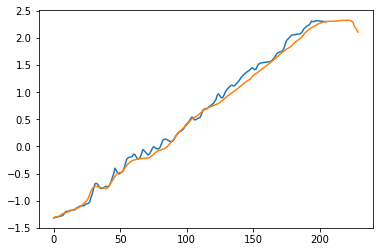

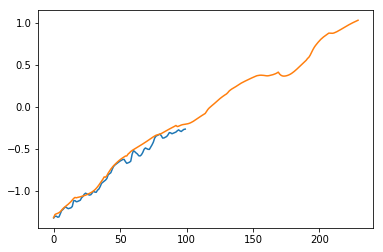

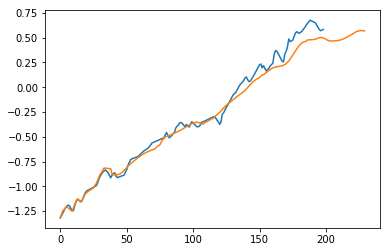

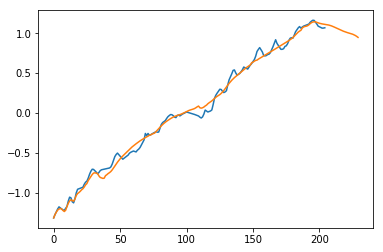

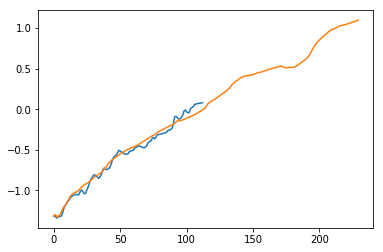

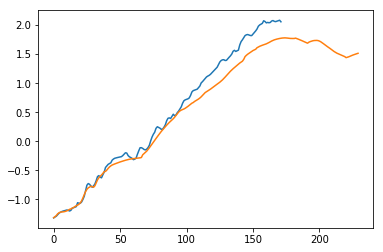

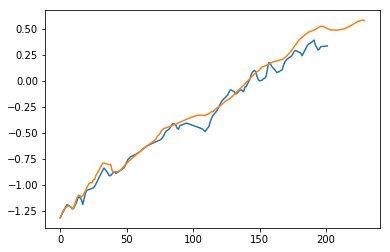

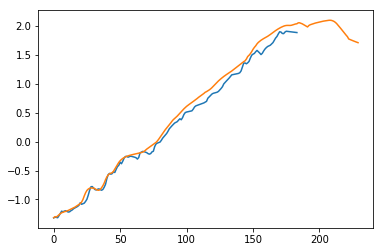

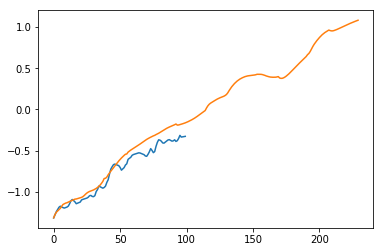

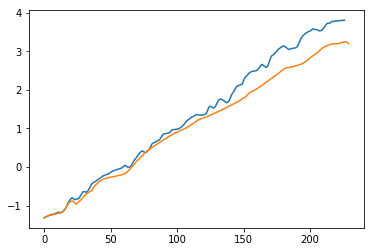

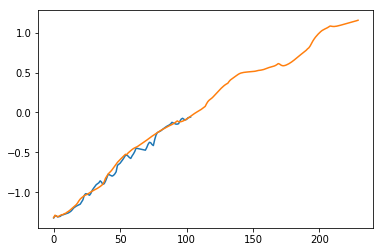

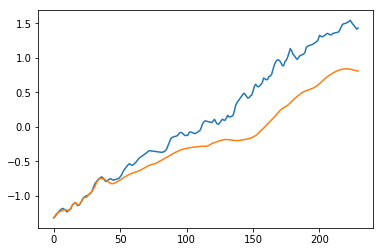

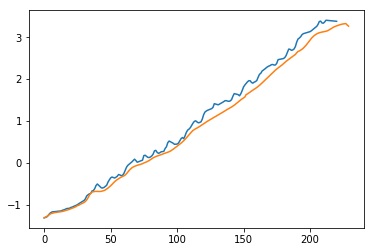

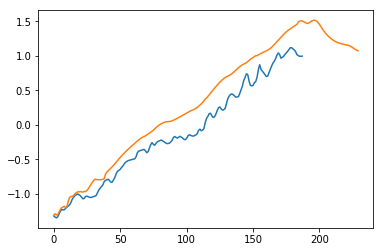

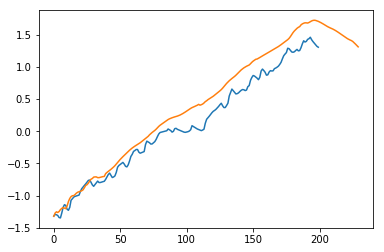

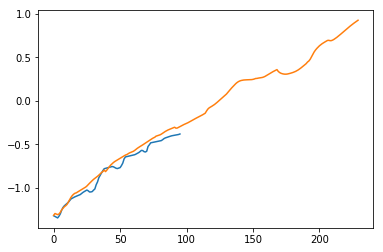

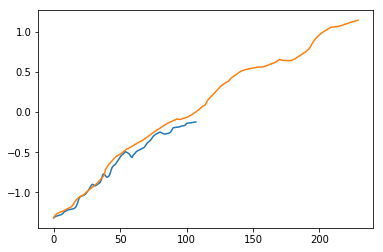

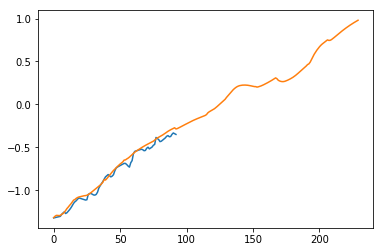

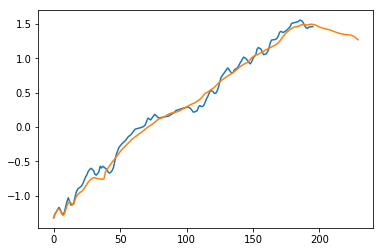

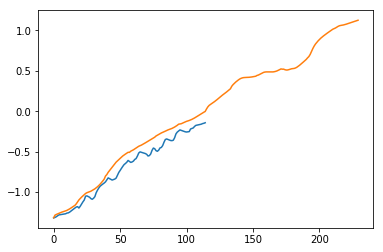

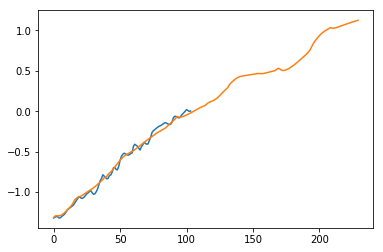

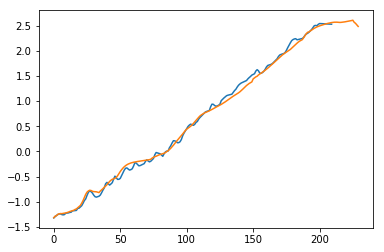

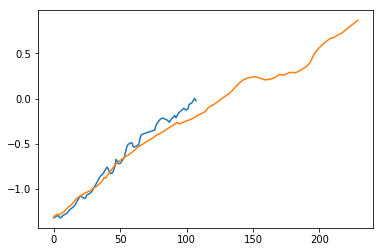

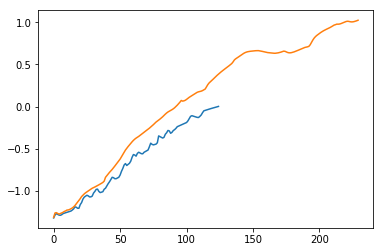

In [43]:
for gt, pred in zip (test_batch_y, preds):
    plt.figure()
    plt.plot(gt[gt != -999])
    plt.hold(True)
    plt.plot(pred)